#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette("deep")

#### Business Objectives
This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of medical procedures. Borrowers can easily access lower interest rate loans through a fast online interface. 

 

Like most other lending companies, lending loans to ‘risky’ applicants is the largest source of financial loss (called credit loss). Credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed. In other words, borrowers who default cause the largest amount of loss to the lenders. In this case, the customers labelled as 'charged-off' are the 'defaulters'. 

 

If one is able to identify these risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss. Identification of such applicants using EDA is the aim of this case study.

 

In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment. 


To develop your understanding of the domain, you are advised to independently research a little about risk analytics (understanding the types of variables and their significance should be enough).

In [2]:
df = pd.read_csv("loan.csv")
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
rows = df.shape[0]
columns = df.shape[1]
df.shape

(39717, 111)

The dataset has 39717 rows with each row having 111 columns

#### Perform data cleaning
1. Fix rows and columns
2. Fixing missing values
3. Standardize values and fix invalid values
5. Filter data

#### 1. Fixing rows and columns


##### 1.1 Fixing columns


Lets try to analyse what is the distribution of nulls across columns

In [4]:
null_analysis = (df.isnull().sum().sort_values(ascending=False)).to_frame(name="null_cnt")
# compute null percent which % of nulls in a given column
null_analysis['null_pct'] = round(100 * null_analysis['null_cnt'] / rows, 2)
null_analysis['null_pct'].value_counts()

null_pct
100.00    54
0.00      43
0.14       2
97.13      1
92.99      1
64.66      1
32.59      1
6.19       1
2.71       1
1.75       1
0.18       1
0.13       1
0.10       1
0.03       1
0.01       1
Name: count, dtype: int64

We can observe that for 54 columns there is no data available at all. Hence we can drop them from our analysis

In [5]:
df = df.dropna(axis=1, how="all")

In [6]:
df.shape

(39717, 57)

Another set of columns eligible for dropping are where all rows have same constant value. From such columns we can never derive any useful information

In [7]:
constant_columns = df.nunique()[df.nunique() == 1]
constant_columns

pymnt_plan                    1
initial_list_status           1
collections_12_mths_ex_med    1
policy_code                   1
application_type              1
acc_now_delinq                1
chargeoff_within_12_mths      1
delinq_amnt                   1
tax_liens                     1
dtype: int64

In [8]:
df = df.drop(constant_columns.index, axis=1)

Also columns having unique values for all rows (like an id) can be dropped

In [9]:
uniques = df.nunique()
uniques = uniques[uniques == df.shape[0]]
uniques.index

Index(['id', 'member_id', 'url'], dtype='object')

In [10]:
df = df.drop(uniques.index, axis=1)

Now lets look at the remaining columns in the dataset

Still there are lot of columns which are irrelevant for this analysis

- string columns like emp_tile, title and desc can be dropped.

- funded_amnt and funded_amnt_inv are similar. Lets drop funded_amnt_inv

- zip code is not complete. For example 945xx. Lets drop it

- A lot of columns describe behavior of the customer after they have been acquired i.e loan was sanctioned. These columns cannot provide any insights to us as our analysis begins before the loan gets sanctioned. For example - collection_recovery_fee, last_credit_pull_d delinq_2yrs etc

In [11]:
df = df.drop(['title', "emp_title", "desc","zip_code", "funded_amnt_inv","collection_recovery_fee", "last_credit_pull_d", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_record", "total_pymnt", "total_pymnt_inv", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d","total_rec_prncp", "out_prncp_inv", "out_prncp", "revol_bal", "revol_util"], axis=1)

In [12]:
df.shape

(39717, 22)

##### 1.2 Fixing rows


Lets check the dataset, whether it has any header/footer or summary rows which can be dropped


In [13]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'total_acc', 'pub_rec_bankruptcies'],
      dtype='object')

Here we can clearly see, all columns are present in the metadata file **Data_Dictionary.xlsx** and none of them are any header/footer or summary columns

Now we can check if any rows are duplicates of each other. If yes we can drop the duplicates

In [14]:
df = df.drop_duplicates()
df.shape

(39717, 22)

Since the number of rows didn't change there were no duplicates in the dataset

In [15]:
df.isna().sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
39712    1
39713    1
39714    1
39715    1
39716    1
Length: 39717, dtype: int64

Lets try to analyse what is the distribution of nulls for rows. We can safely remove rows where lot of its columns have null values


In [16]:
df

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,loan_status,purpose,addr_state,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,total_acc,pub_rec_bankruptcies
0,5000,5000,36 months,10.65%,162.87,B,B2,10+ years,RENT,24000.0,...,Fully Paid,credit_card,AZ,27.65,Jan-85,1,3,0,9,0.0
1,2500,2500,60 months,15.27%,59.83,C,C4,< 1 year,RENT,30000.0,...,Charged Off,car,GA,1.00,Apr-99,5,3,0,4,0.0
2,2400,2400,36 months,15.96%,84.33,C,C5,10+ years,RENT,12252.0,...,Fully Paid,small_business,IL,8.72,Nov-01,2,2,0,10,0.0
3,10000,10000,36 months,13.49%,339.31,C,C1,10+ years,RENT,49200.0,...,Fully Paid,other,CA,20.00,Feb-96,1,10,0,37,0.0
4,3000,3000,60 months,12.69%,67.79,B,B5,1 year,RENT,80000.0,...,Current,other,OR,17.94,Jan-96,0,15,0,38,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,2500,2500,36 months,8.07%,78.42,A,A4,4 years,MORTGAGE,110000.0,...,Fully Paid,home_improvement,CO,11.33,Nov-90,0,13,0,40,NaN
39713,8500,8500,36 months,10.28%,275.38,C,C1,3 years,RENT,18000.0,...,Fully Paid,credit_card,NC,6.40,Dec-86,1,6,0,9,NaN
39714,5000,5000,36 months,8.07%,156.84,A,A4,< 1 year,MORTGAGE,100000.0,...,Fully Paid,debt_consolidation,MA,2.30,Oct-98,0,11,0,20,NaN
39715,5000,5000,36 months,7.43%,155.38,A,A2,< 1 year,MORTGAGE,200000.0,...,Fully Paid,other,MD,3.72,Nov-88,0,17,0,26,NaN


In [17]:
df.isna().sum(axis=1).max()

1

Rows look good. Not many nulls

#### 2. Fixing missing values


After removing irrelevant columns lets analyse the missing values

In [18]:
(df.isna().sum()[df.isna().sum() > 0]/df.shape[0])*100

emp_length              2.706650
pub_rec_bankruptcies    1.754916
dtype: float64

In [19]:
((df.isna().sum()[df.isna().sum() > 0]) / df.shape[0]) * 100

emp_length              2.706650
pub_rec_bankruptcies    1.754916
dtype: float64

Only two columns have some nulls. Lets try to fix those values. Since very few rows have this problem, we can just put the mode in the place of empty

In [20]:
df['emp_length'] = df['emp_length'].fillna(df['emp_length'].mode().values[0])

In [21]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].mode().values[0])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39717 non-null  int64  
 1   funded_amnt           39717 non-null  int64  
 2   term                  39717 non-null  object 
 3   int_rate              39717 non-null  object 
 4   installment           39717 non-null  float64
 5   grade                 39717 non-null  object 
 6   sub_grade             39717 non-null  object 
 7   emp_length            39717 non-null  object 
 8   home_ownership        39717 non-null  object 
 9   annual_inc            39717 non-null  float64
 10  verification_status   39717 non-null  object 
 11  issue_d               39717 non-null  object 
 12  loan_status           39717 non-null  object 
 13  purpose               39717 non-null  object 
 14  addr_state            39717 non-null  object 
 15  dti                

#### 3. Standardize columns


We will inspect the columns and fix types and any outliers present. Outliers will negatively impact our analysis. We can follow a rule  [Q1 – 1.5 IQR, Q3 + 1.5 IQR] as range for data. We will use boxplot for our outlier analysis

In [23]:
def outlier_range(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    return (lower_limit, upper_limit)

#####  1. int_rate

In [24]:
df['int_rate'] = df['int_rate'].apply(lambda x: x[:-1]).astype("float64") # Removing the percentage sign to make it numeric

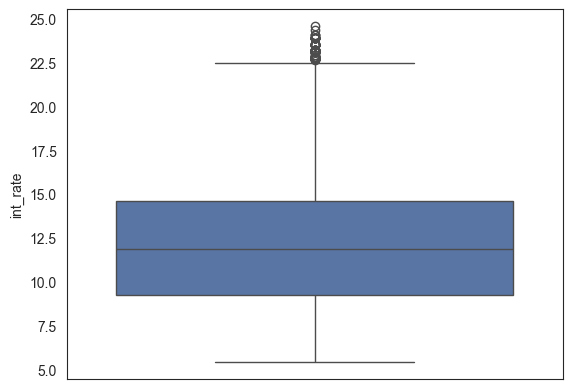

In [25]:
sns.boxplot(data=df, y="int_rate")
plt.show()

Since int_rate is a continuous variable, it makes sense creating ranges out of it to analyse

In [26]:
df['int_rate'].describe()

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64

In [27]:
df['int_rate_range'] = pd.cut(df['int_rate'], bins=[0,10, 12.5, 15, 25], labels=["0-10%", "10-12.5%", "12.5-15%", '15%+'] , precision=0)

#####  2. sub_grade

In [28]:
def check_sub_grade(row):
    """
    Checks if sub grade's grade matches
    For example A1 grade should be A and not B
    """
    return row['grade'] == row['sub_grade'][0]

df[["grade", "sub_grade"]].apply(check_sub_grade, axis=1).sum()

39717

We can see sub_grade is valid. Since sub grade includes the grade prefix we can drop that and just have an ordinal number as the sub grade. For example A2 can be changed to just 2

In [29]:
df['sub_grade'] = df['sub_grade'].apply(lambda x : x[1:]).astype("int64")

#####  3. emp_length

In [30]:
df['emp_length'].value_counts()

emp_length
10+ years    9954
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
Name: count, dtype: int64

Lets make emp_length as numeric ordinal. We can have the units as years. <1 years can be treated as 0 where as 10+ can be treated as 10 for this analysis.

In [31]:
def parse_emp_length(length):
    length = str(length)
    # Note - this function is very specific to the dataset. This may not work if dataset changes
    if "<" in length:
        return 0
    elif "+" in length:
        return 10
    else:
        return int(length[0])

df['emp_length'] = df['emp_length'].apply(parse_emp_length)

From employment length we can derive experience level. Junior (0-3years), Senior (3-7years) and Staff (7+years)

In [32]:
df['exp_level'] = pd.cut(df['emp_length'], bins=[0,3,7,10], include_lowest=True, labels=["Junior", "Senior", "Staff"])

In [33]:
df['emp_length']

0        10
1         0
2        10
3        10
4         1
         ..
39712     4
39713     3
39714     0
39715     0
39716     0
Name: emp_length, Length: 39717, dtype: int64

#####  4. issue_d and earliest_cr_line

The issue_d/earliest_cr_line columns comprises of month and year. We can store this information in separate columns and drop issue_d & earliest_cr_line after that

In [34]:
df['issue_year'] = pd.to_datetime(df['issue_d'], format='%b-%y').apply(lambda x: x.year)
df['issue_month'] = pd.to_datetime(df['issue_d'], format='%b-%y').apply(lambda x: x.month_name()[0:3])
df['earliest_cr_line_year'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y').apply(lambda x: x.year)
max_issue_year = df['issue_year'].max()
df['earliest_cr_line_year'] = df['earliest_cr_line_year'].apply(lambda x: x - 100 if x > max_issue_year else x)

labels = [f"{x}" for x in range(1940,2020,10)]

df['earliest_cr_line_decade'] = pd.cut(df['earliest_cr_line_year'], bins=len(labels), labels=labels , precision=0)

df = df.drop(["issue_d","earliest_cr_line","earliest_cr_line_year"], axis=1)

#####  5. pub_rec / pub_rec_bankruptcies

In [35]:
df['pub_rec_bankruptcies'] = pd.cut(df['pub_rec_bankruptcies'], bins=[-1,0,3], labels=["0", "1+"])

In [36]:
df['pub_rec'] = pd.cut(df['pub_rec'], bins=[-1,0,5], labels=["0", "1+"])

##### 6. annual_inc


Lets plot a boxplot to observe the outliers in annual_inc data

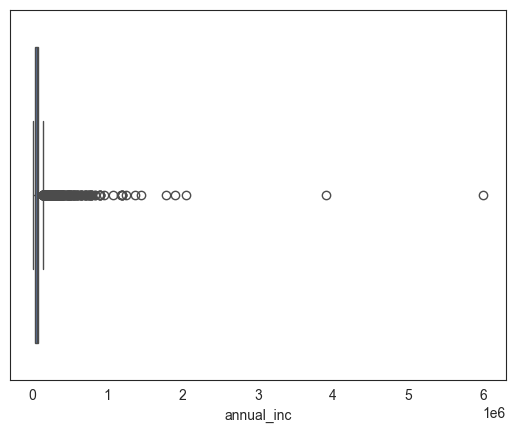

In [37]:
sns.boxplot(data=df, x="annual_inc")
plt.show()

As we can observe there are too many outliers here. We cannot even see the 25th & 75th percentile in this graph properly. Lets weed out most of the outliers here

In [38]:
lower_limit, upper_limit = outlier_range(df, "annual_inc")
print(f"Lower Limit: {lower_limit}")
print(f"Upper Limit: {upper_limit}")

Lower Limit: -22440.0
Upper Limit: 145144.0


In [39]:
df = df[(df['annual_inc'] <= upper_limit)]

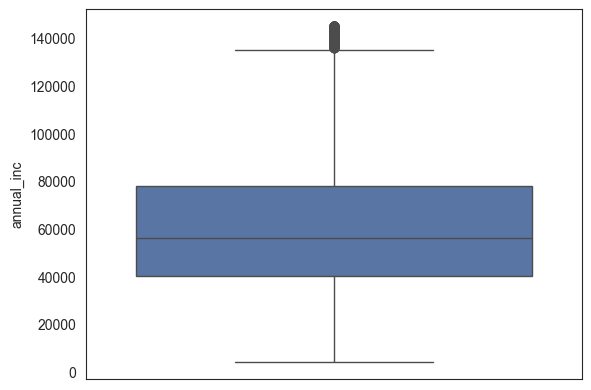

In [40]:
sns.boxplot(data=df, y="annual_inc")
plt.show()

Now outliers have been reduced substantially. Since annual_inc is a continuous variable, we can create ranges for better analysis

In [41]:
print(f"Min income: {df['annual_inc'].min()} and max income: {df['annual_inc'].max()}")

Min income: 4000.0 and max income: 145008.0


Lets create 6 buckets here each of 25K

In [42]:
df['annual_inc_range'] = pd.cut(df['annual_inc'], bins=6, precision=0, labels=[f"{x-25}K-{x}K" for x in range(25,175,25)])

In [43]:
df['annual_inc_range']

0           0K-25K
1          25K-50K
2           0K-25K
3          25K-50K
4         75K-100K
           ...    
39711     75K-100K
39712    100K-125K
39713       0K-25K
39714    100K-125K
39716       0K-25K
Name: annual_inc_range, Length: 37874, dtype: category
Categories (6, object): ['0K-25K' < '25K-50K' < '50K-75K' < '75K-100K' < '100K-125K' < '125K-150K']

##### 7. loan_amnt & funded_amnt

loan_amnt is the amount requested by the customer whereas funded_amnt is the approved amount from the LC. So by that logic loan_amnt >= funded_amnt. Lets verify that

In [44]:
(df['loan_amnt'] < df['funded_amnt']).sum()

0

Also by definition loan_amnt & funded_amnt will be highly correlated. We can confirm using the dataset

In [45]:
df[['loan_amnt', "funded_amnt"]].corr()

,loan_amnt,funded_amnt
loan_amnt,1.000000,0.981827
funded_amnt,0.981827,1.000000


In [46]:
df[['loan_amnt','funded_amnt']].corr()

,loan_amnt,funded_amnt
loan_amnt,1.000000,0.981827
funded_amnt,0.981827,1.000000


In [47]:
funding_ratio = df['funded_amnt'] / df['loan_amnt']
df = df.drop(['funded_amnt'], axis=1)

In [48]:
funding_ratio.describe()

count    37874.000000
mean         0.986253
std          0.068624
min          0.101250
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

Funding ratio 25 to 75th percentile is 1. So this is heavily skewed towards 1 meaning almost all loans are fully funded. This will not give us any insight. We can drop it

Usually installment depends on the loan_amount. We can check this and if they are highly correlated we can drop installment from analysis

In [49]:
df[['loan_amnt', 'installment']].corr()

,loan_amnt,installment
loan_amnt,1.000000,0.929649
installment,0.929649,1.000000


In [50]:
df = df.drop(['installment'], axis=1)

Lets  plot the distribution as a boxplot for loan_amnt in order to identify any outliers here

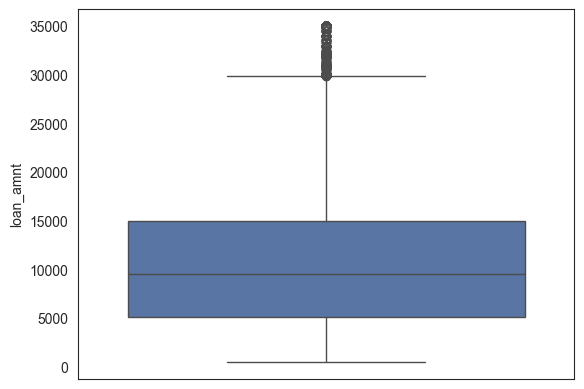

In [51]:
sns.boxplot(data=df, y='loan_amnt')
plt.show()

There are few outliers all between 30K and 35K. This should be ok to work with

Loan amount is a continuous variable. It would be good for analysis if we also have loan ranges

In [52]:
print(f"Min loan: {df['loan_amnt'].min()} and max income: {df['loan_amnt'].max()}")

Min loan: 500 and max income: 35000


Lets create buckets with each bucket having a interval of 5K

In [53]:
labels = [f"{x-10}K-{x}K" for x in range(10,50,10)]

In [54]:
df['loan_amnt_range'] =  pd.cut(df['loan_amnt'], bins=len(labels), precision=0, labels=labels)

If we think logically more the annual income, a person can take out more loan amount. We can define loan_ratio as loan_amnt/annual_inc

In [55]:
df['loan_ratio'] = 100 * df['loan_amnt'] / df['annual_inc']

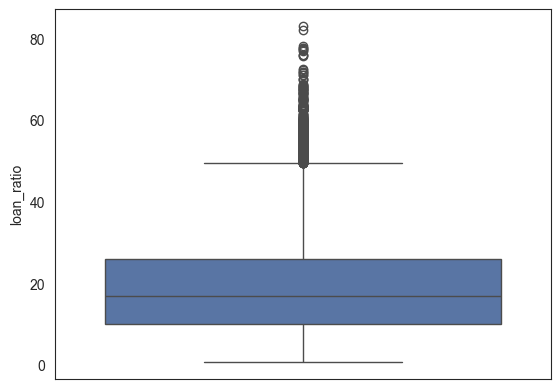

In [56]:
sns.boxplot(data=df, y="loan_ratio")
plt.show()

In [57]:
df['loan_ratio_range'] = pd.cut(df['loan_ratio'], bins=[0,20,40,100], include_lowest=True, labels=["0-20%", "20-40%", "40%+"]) 

##### 8. dti

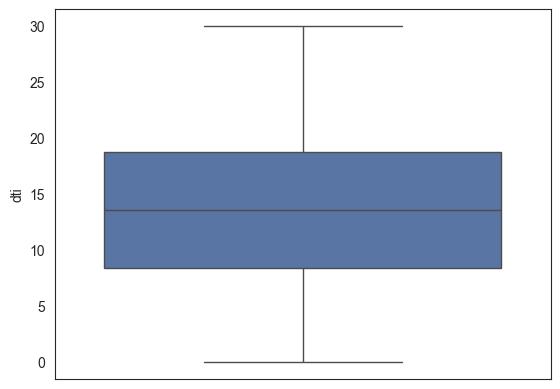

In [58]:
sns.boxplot(data=df, y="dti")
plt.show()

No outliers here. This is fine

Lets create buckets similar to earlier continuous variables here as well. Here we can directly replace the dti column

In [59]:
print(f"Min dti: {df['dti'].min()} and max dti: {df['dti'].max()}")

Min dti: 0.0 and max dti: 29.99


In [60]:
df['dti_range'] =pd.cut(df['dti'], [0, 5, 10, 15, 30] ,labels=['0%-5%', '5%-10%', '10%-15%', "15%+"], include_lowest=True)

##### 9. open_acc, total_acc

total_acc is total credit lines for the customer where as open_acc is the credit lines currently open. Lets validate where open_acc is always less or equal to total_acc

In [61]:
df[(df['open_acc'] > df['total_acc'])].shape[0]

1

In [62]:
df[['total_acc', 'open_acc']].corr()

,total_acc,open_acc
total_acc,1.000000,0.683555
open_acc,0.683555,1.000000


Instead of maintaining two columns we can just define a open_acc_ratio which is open_acc / total_acc to remove correlation. Then we can drop the earlier two columns

In [63]:
df['open_acc_ratio'] = df['open_acc'] / df['total_acc'] * 100
df = df.drop(['open_acc', 'total_acc'], axis=1)

[]

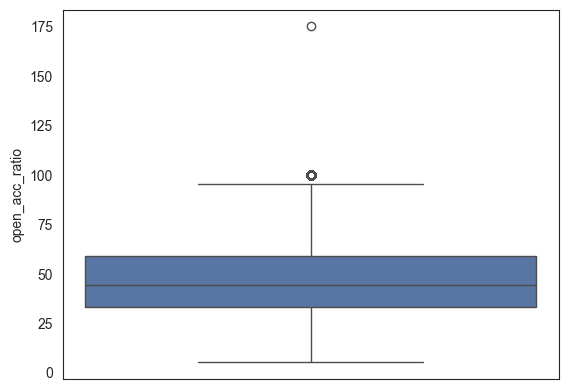

In [64]:
sns.boxplot(data=df, y="open_acc_ratio")
plt.plot()

In [65]:
df['open_acc_ratio_range'] = pd.cut(df['open_acc_ratio'], bins=[0,25,50,75,200], precision=0, labels=["0%-25%", "25%-50%", "50%-75%", "75%+"])

In [66]:
df = df.drop("open_acc_ratio", axis=1)

##### 10. inq_last_6mths

[]

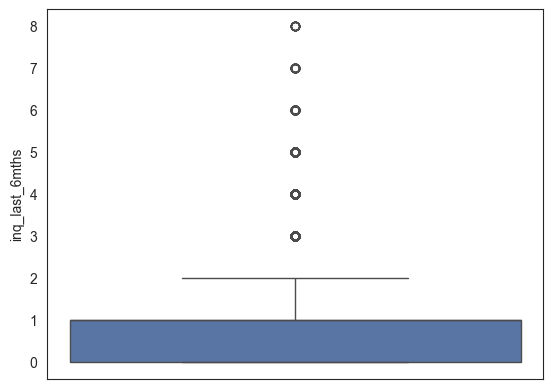

In [67]:
sns.boxplot(data=df, y="inq_last_6mths")
plt.plot()

In [68]:
df['inq_last_6mths_range'] = pd.cut(df['inq_last_6mths'], bins=[-1,0,10], labels=["0", "1+"])

In [69]:
df = df.drop("inq_last_6mths", axis=1)

##### 11. term

In [70]:
df['term'].value_counts()

term
 36 months    27838
 60 months    10036
Name: count, dtype: int64

Lets convert term which is in month to integer. We can also rename the column to term_months

In [71]:
df['term_months'] = df['term'].apply(lambda x : int(x.split("months")[0]))
df = df.drop(["term"], axis=1)

#### 4. Filter data

Lets observe the unique values of the target column **loan_status**

In [72]:
df['loan_status'].value_counts()

loan_status
Fully Paid     31386
Charged Off     5431
Current         1057
Name: count, dtype: int64

Since the analysis is only for loans Fully Paid / Charged Off we can safely drop rows where loan_status is Current

In [73]:
df = df[~(df['loan_status'] == 'Current')]
df.shape

(36817, 27)

We started with 39717 rows and 111 columns and after cleaning we are now have 36817 rows and 25 columns. We can now start with the analysis of data to draw inferences

#### Univariate Analysis

In [74]:
cont_columns = ["loan_amnt", "annual_inc", "int_rate", "dti"]

In [75]:
cat_columns = ["loan_status","grade", "exp_level", "home_ownership", "verification_status","purpose", "pub_rec", "pub_rec_bankruptcies","int_rate_range", "issue_year", "issue_month","earliest_cr_line_decade","annual_inc_range","loan_amnt_range","loan_ratio_range", "dti_range","open_acc_ratio_range","inq_last_6mths_range", "term_months", "addr_state"]

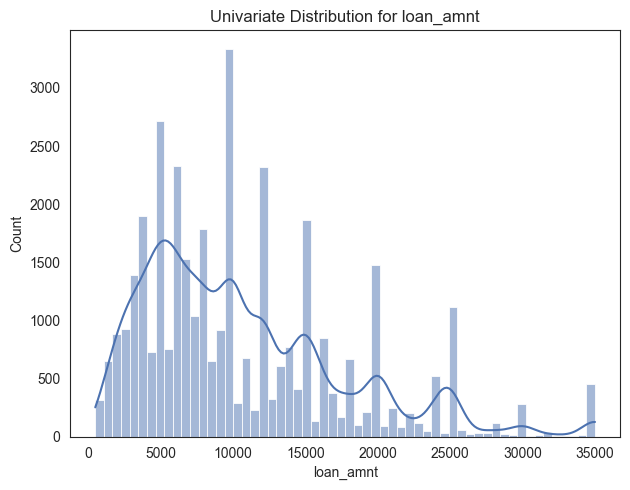

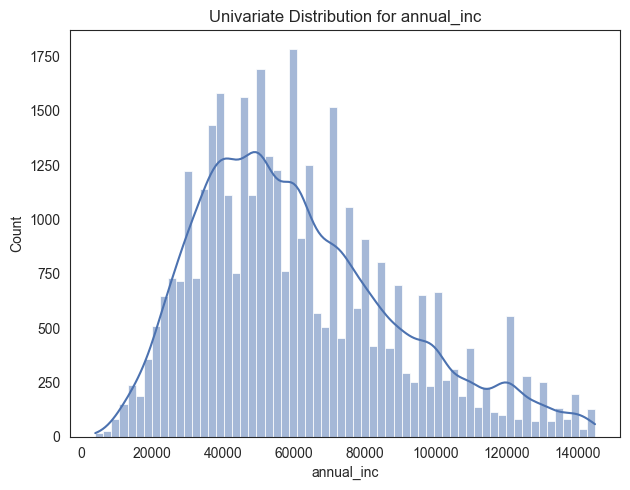

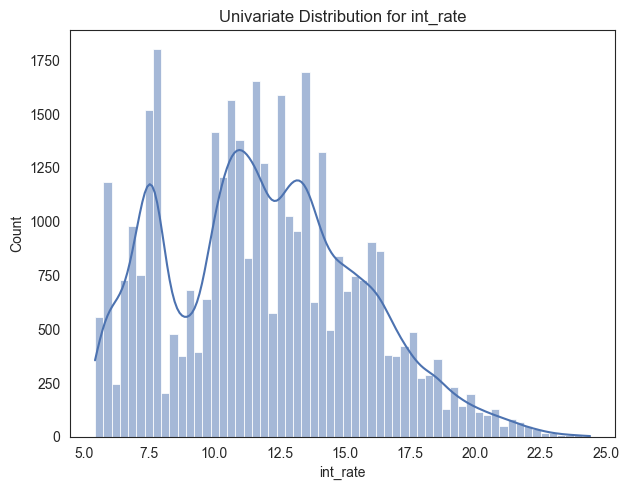

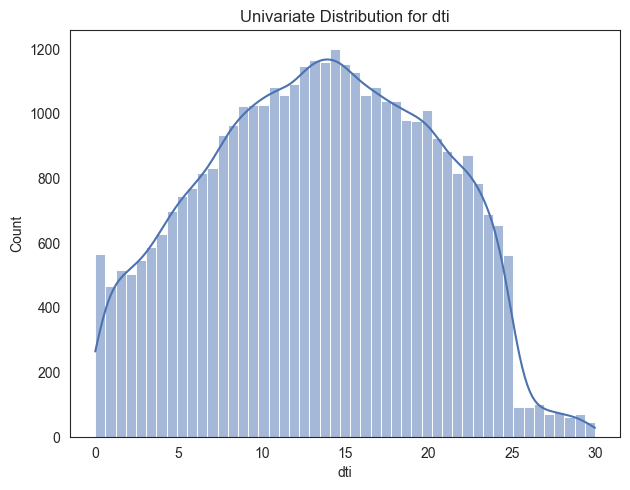

In [76]:
for i in cont_columns:
    sns.histplot(df[i], kde=True, palette=sns.color_palette("deep"))
    plt.tight_layout()
    plt.title(f"Univariate Distribution for {i}")
    plt.show()

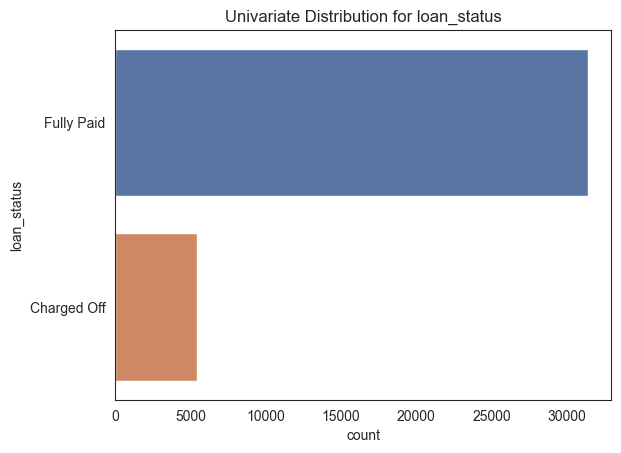

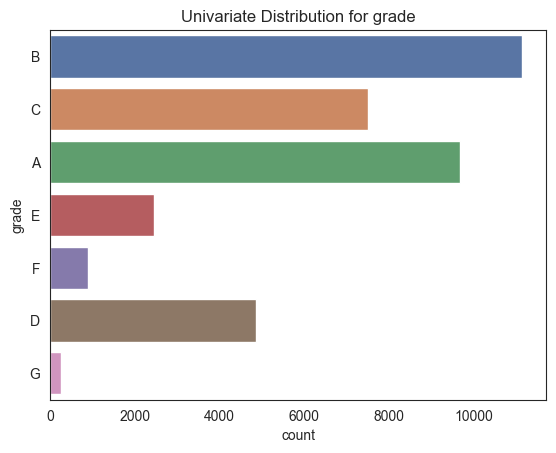

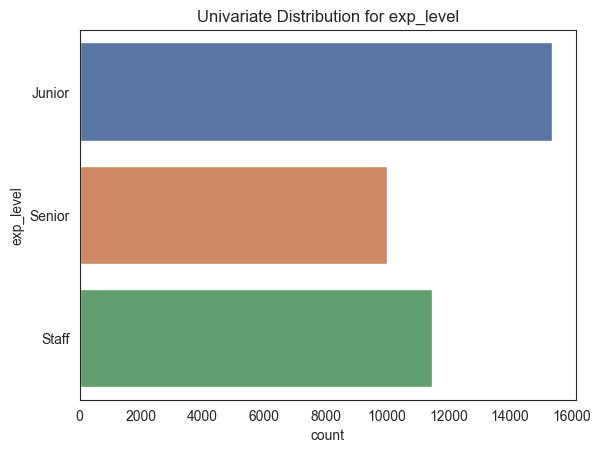

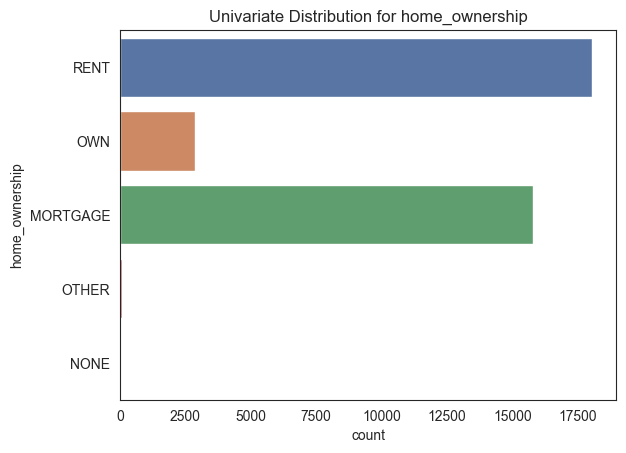

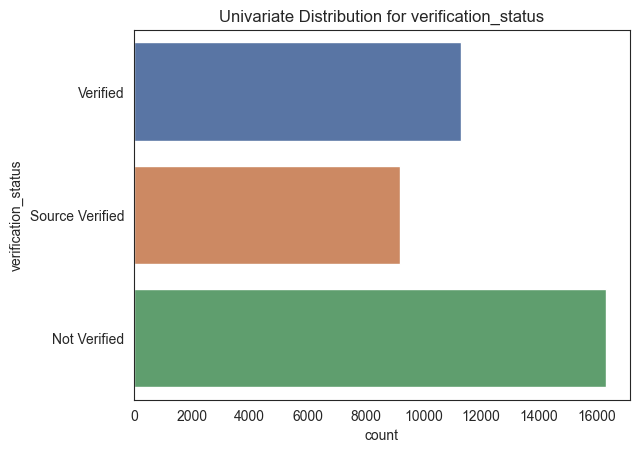

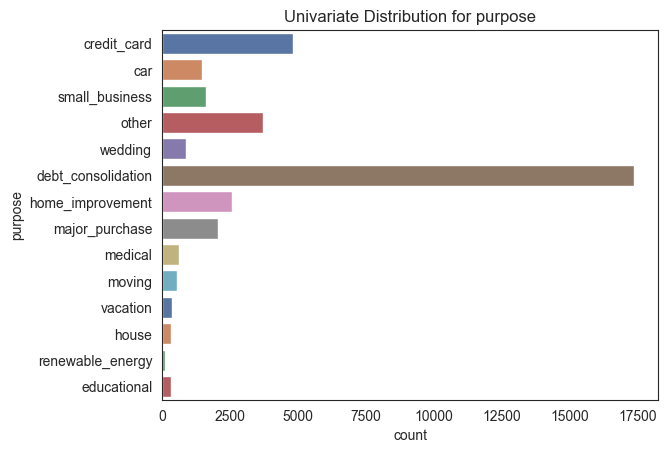

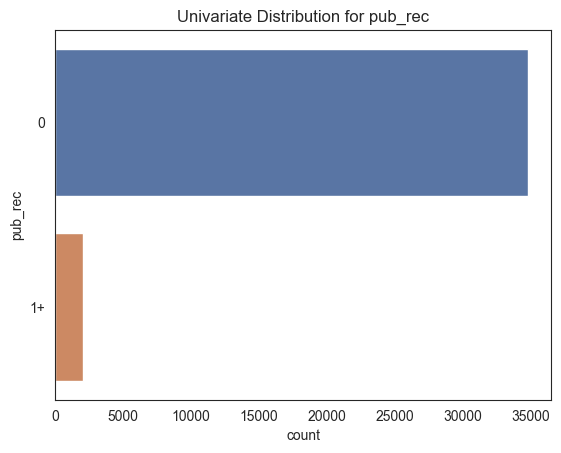

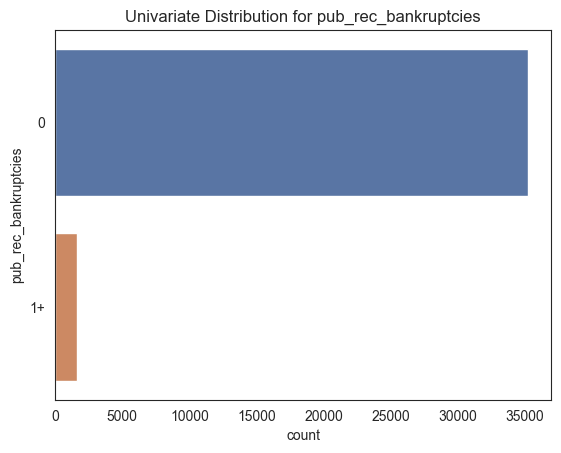

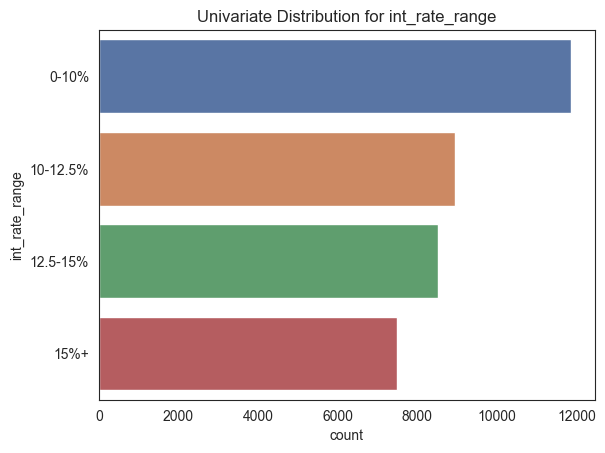

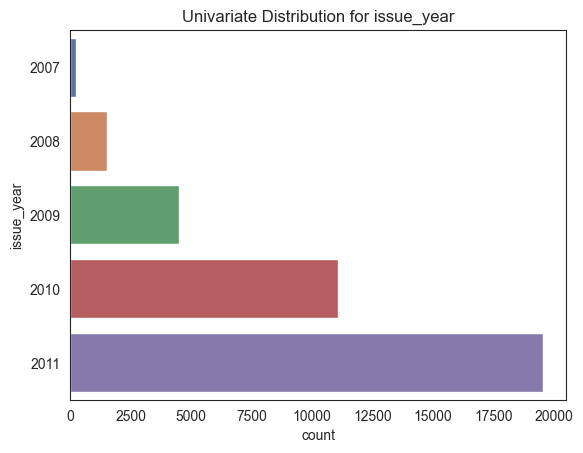

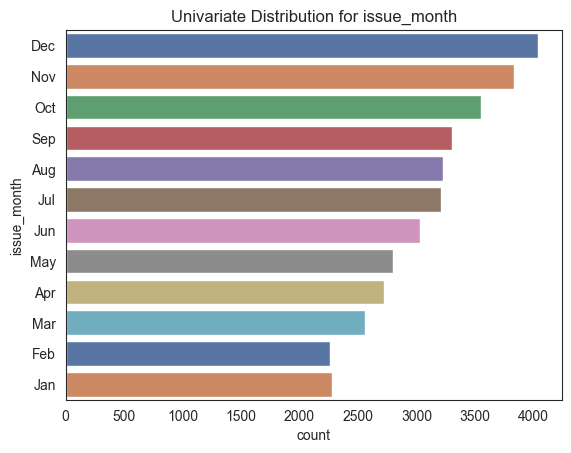

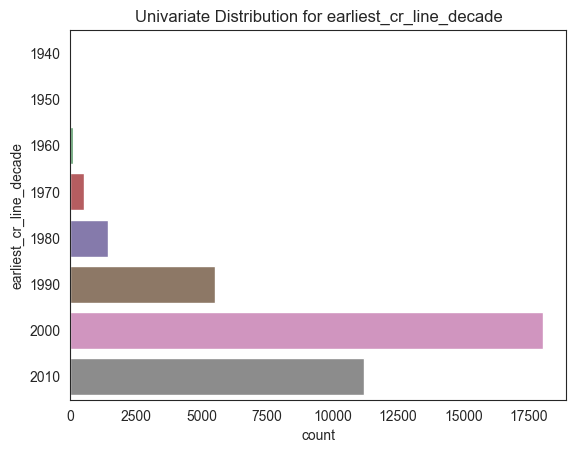

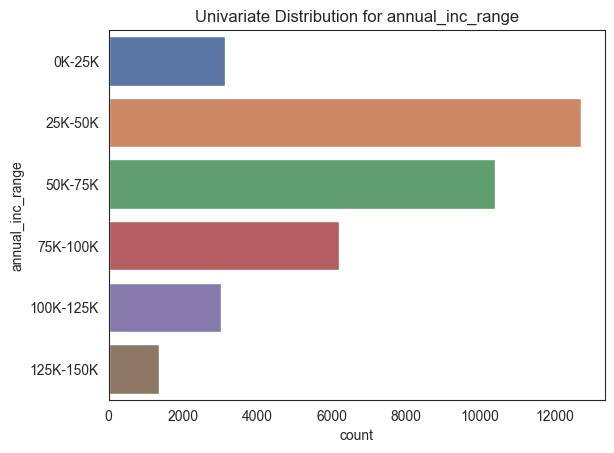

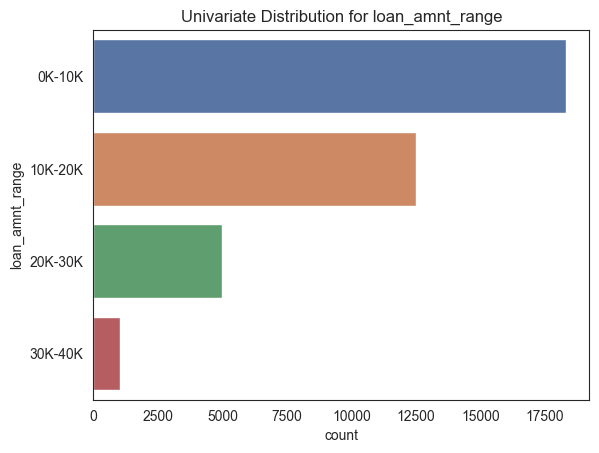

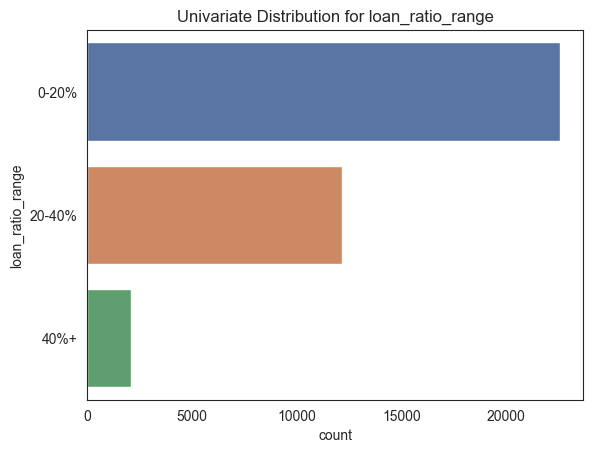

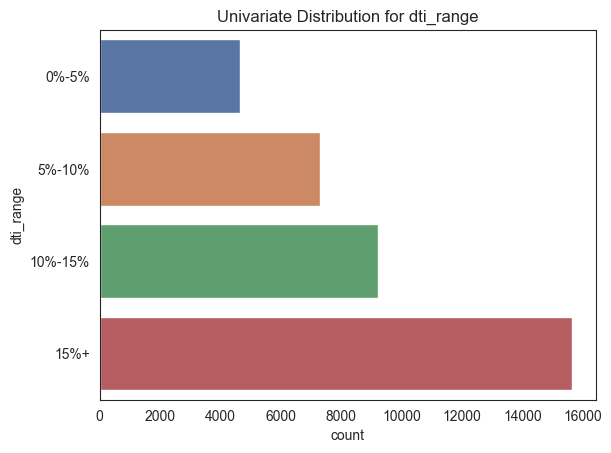

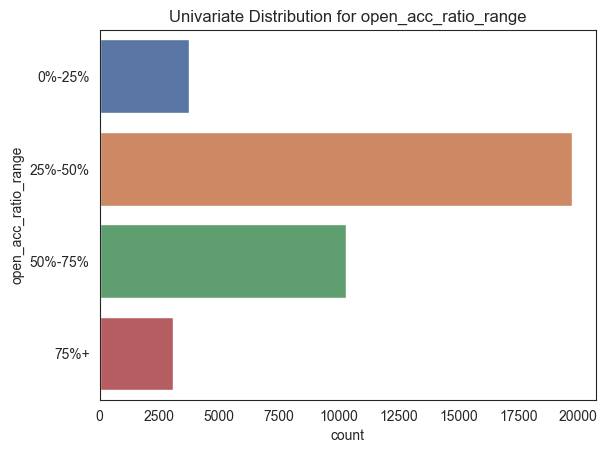

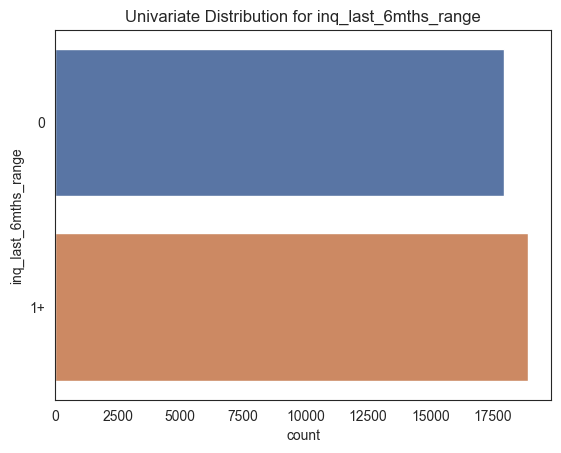

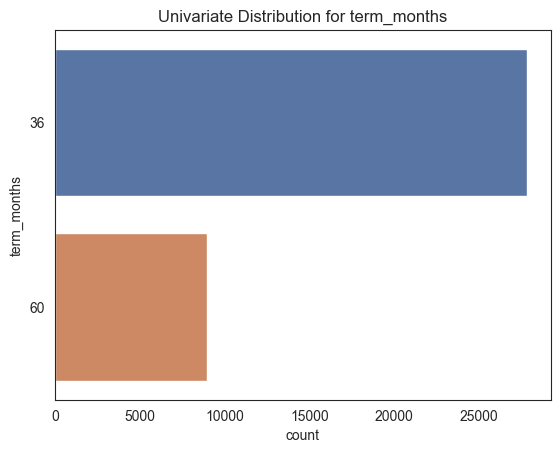

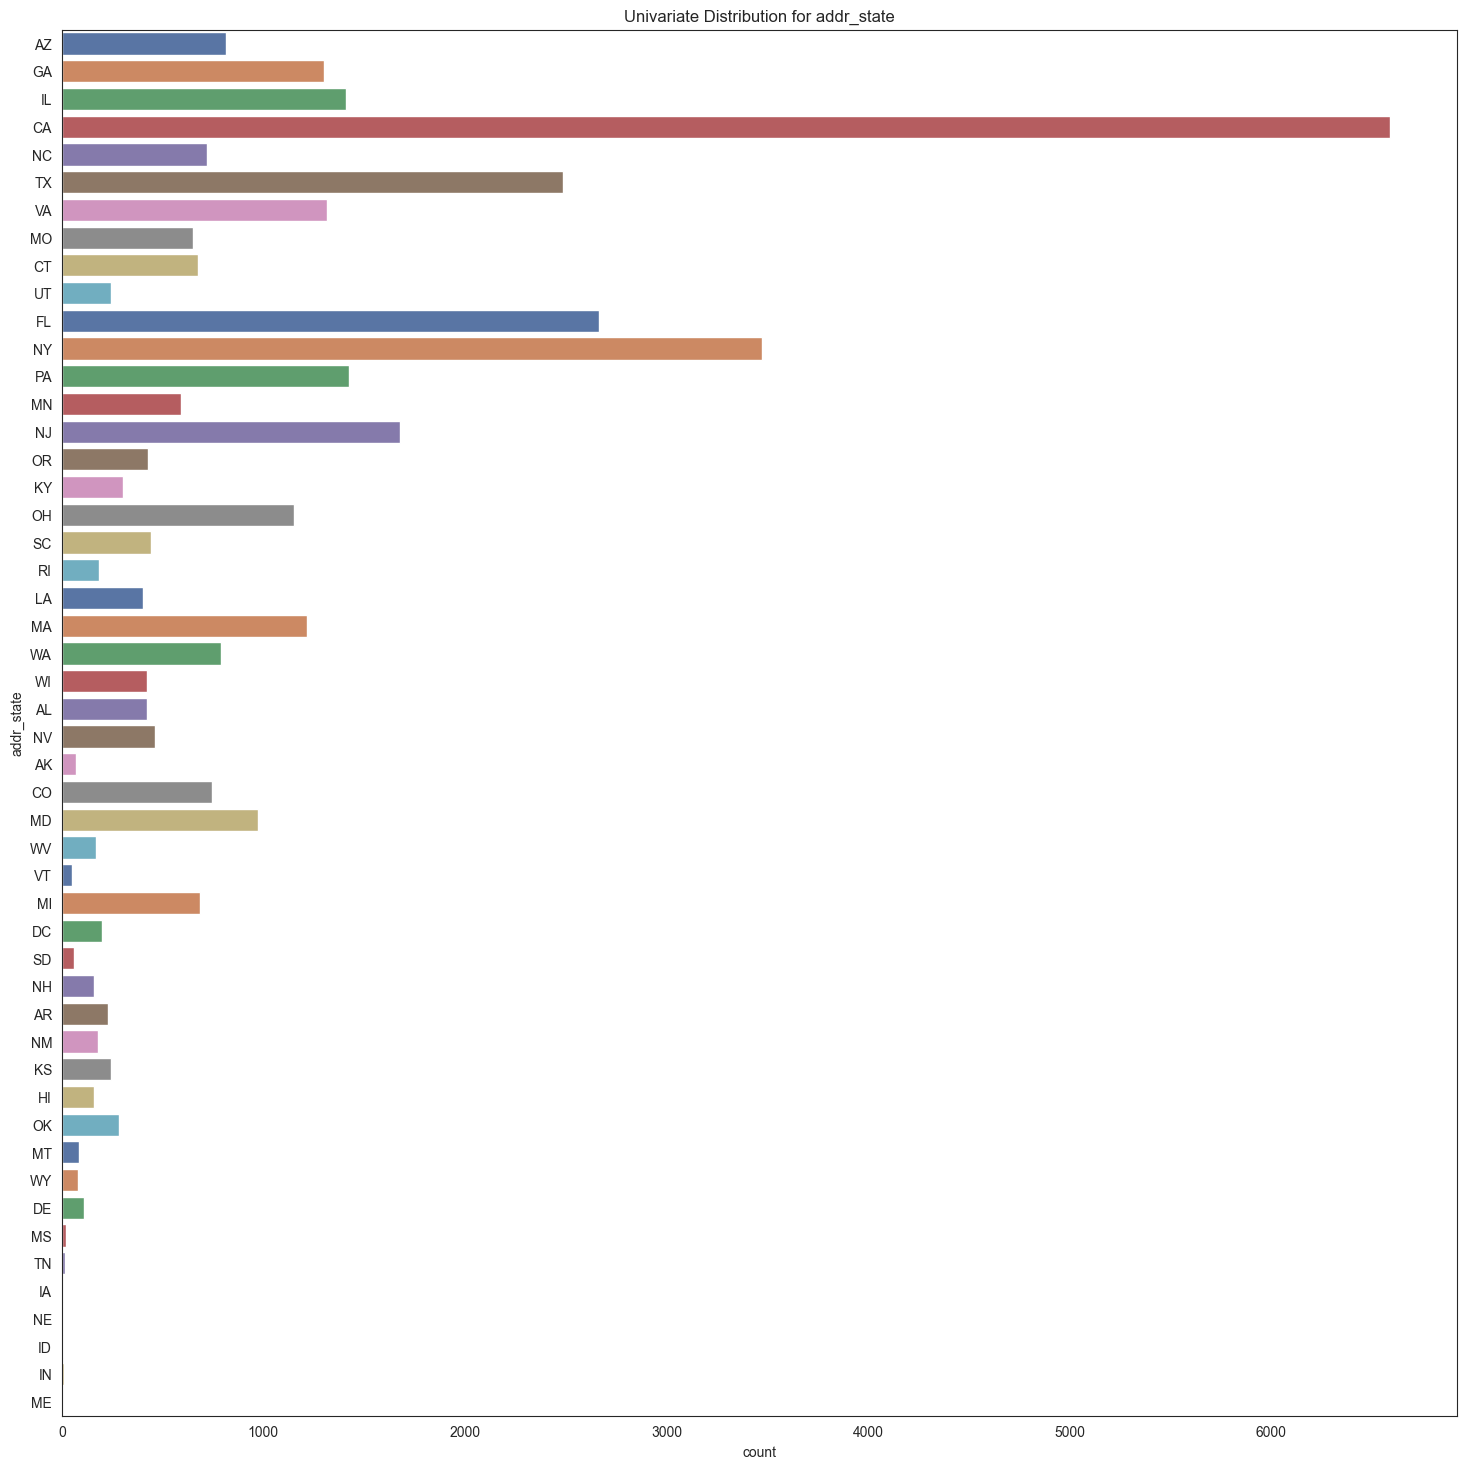

In [77]:
for i in cat_columns:
    if i == "addr_state":
        plt.figure(figsize=(18,18))
    sns.countplot(data=df, y=i, palette=sns.color_palette("deep"))
    plt.title(f"Univariate Distribution for {i}")
    plt.show()

#### Bivariate / Multivariate Analysis

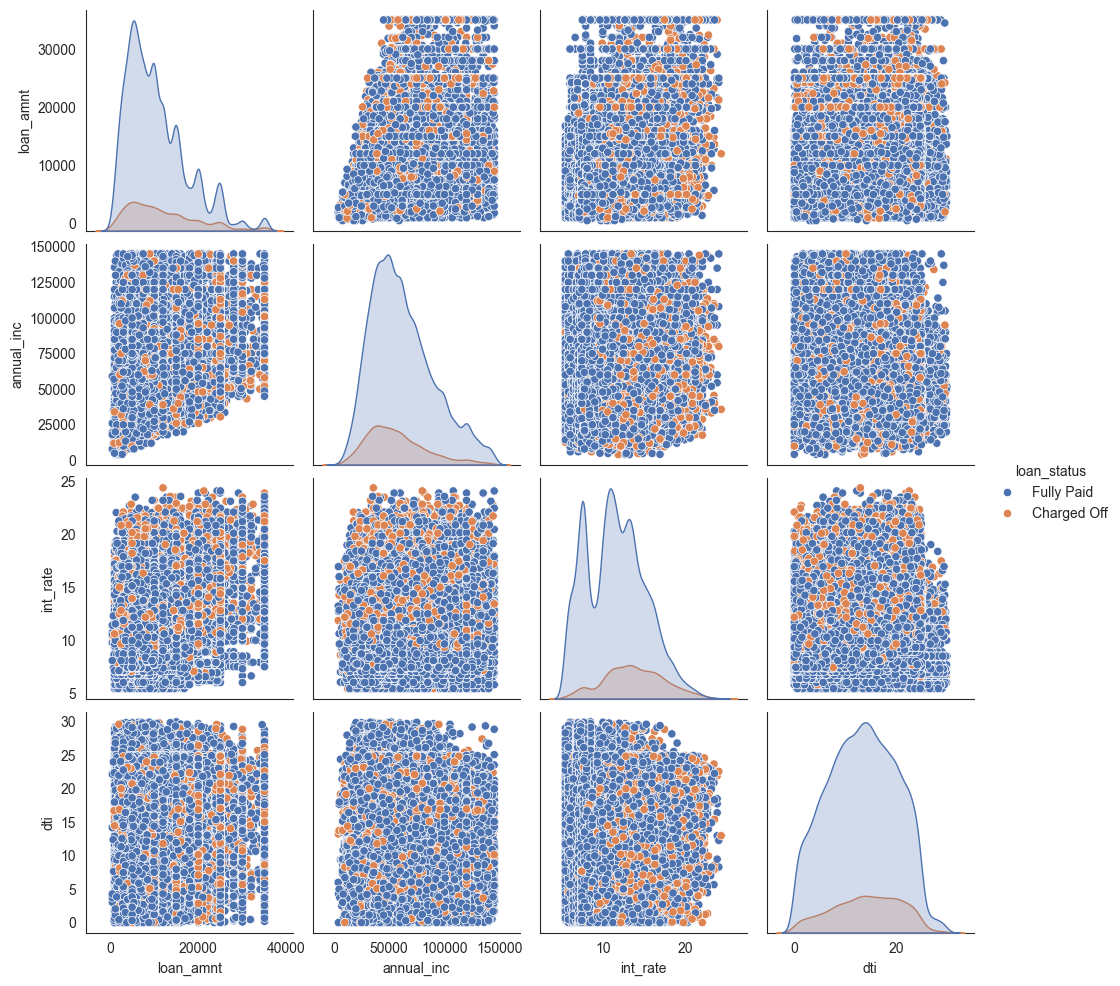

In [78]:
sns.pairplot(data=df[cont_columns+ ["loan_status"]], hue="loan_status")
plt.show()

In [79]:
def analysis_by_loan_status(df, column, display_name=None, figsize=(15,5), rotate_xticks=False, order=None, top_k=None):
    plt.clf()
    f,ax = plt.subplots(2, 1, figsize=figsize)
    palette = sns.color_palette("deep")
    f.subplots_adjust(hspace=0.7)
    new_df = df
    cent = round(100 * df[df['loan_status'] == "Charged Off"][column].value_counts() / df[column].value_counts()).reset_index()
    if top_k:
        values = df[column].value_counts().sort_values(ascending=False).reset_index().iloc[0:top_k][column].values
        new_df = df[df[column].isin(values)]
        cent = cent[cent[column].isin(values)]
    sns.countplot(data=new_df, y=column, hue="loan_status", ax=ax[0], order=order, palette=palette)
    sns.barplot(data=cent, y=column, x="count", ax=ax[1],order=order, palette=palette)
    name = display_name if display_name else column
    ax[0].set_xlabel("Loans issued")
    ax[0].set_ylabel(display_name if display_name else column)
    ax[0].set_title(f"Distribution of Loans by {name}")
    ax[1].set_xlabel("Percent Charged Off")
    ax[1].set_ylabel(display_name if display_name else column)
    ax[1].set_title(f"Percent of Loans Charged Off by {name}")
    ax[0].legend(title="Loan Status")
    if rotate_xticks:
        ax[0].tick_params(axis='x',labelrotation=90)
        ax[1].tick_params(axis='x',labelrotation=90)
    plt.show()

<Figure size 640x480 with 0 Axes>

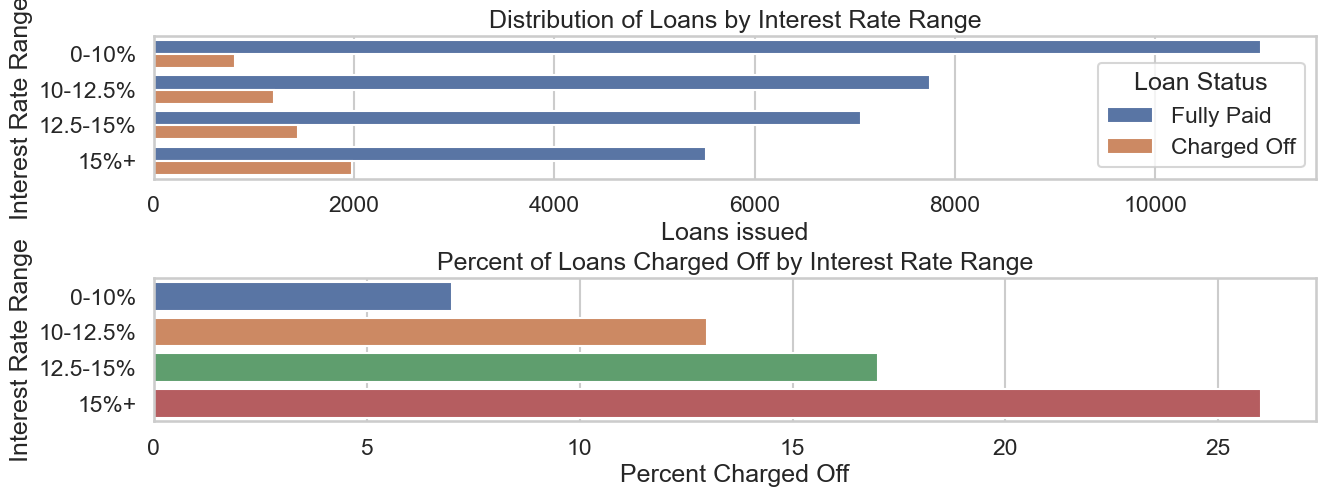

In [98]:
analysis_by_loan_status(df, "int_rate_range", display_name="Interest Rate Range")

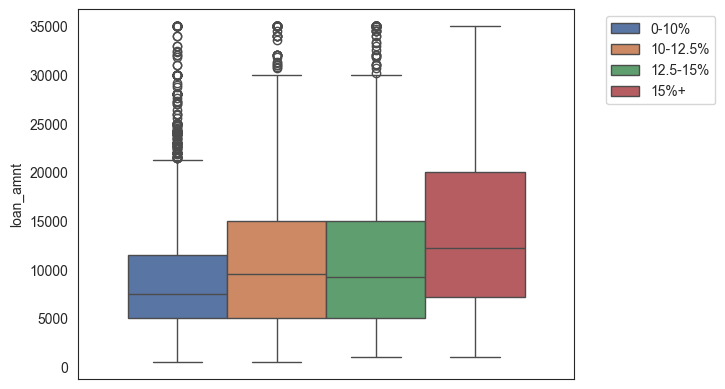

In [81]:
sns.boxplot(data=df, y="loan_amnt", hue="int_rate_range")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<Figure size 640x480 with 0 Axes>

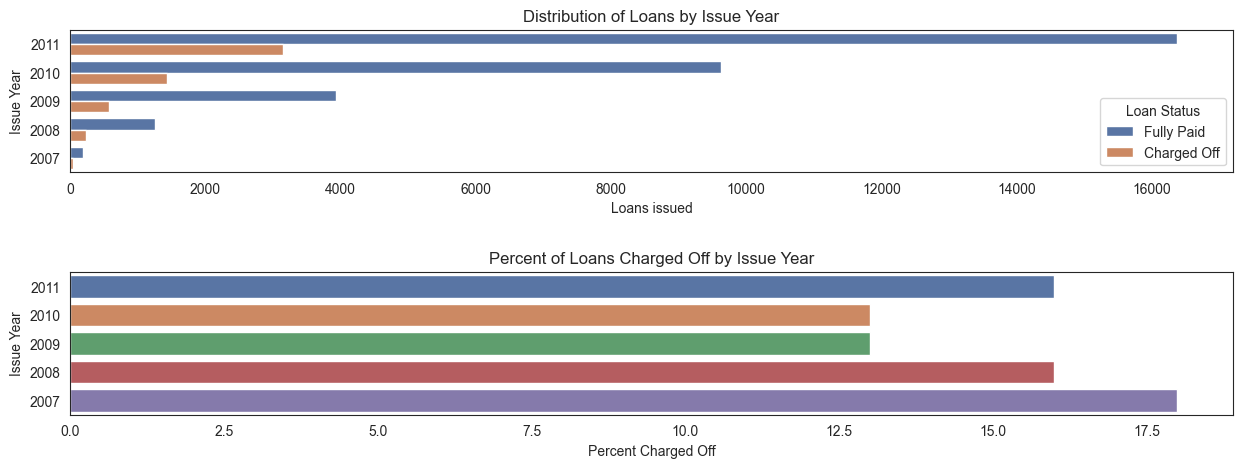

In [82]:
df['issue_year'] = df['issue_year'].astype("str")
analysis_by_loan_status(df, "issue_year", display_name="Issue Year")

<Figure size 640x480 with 0 Axes>

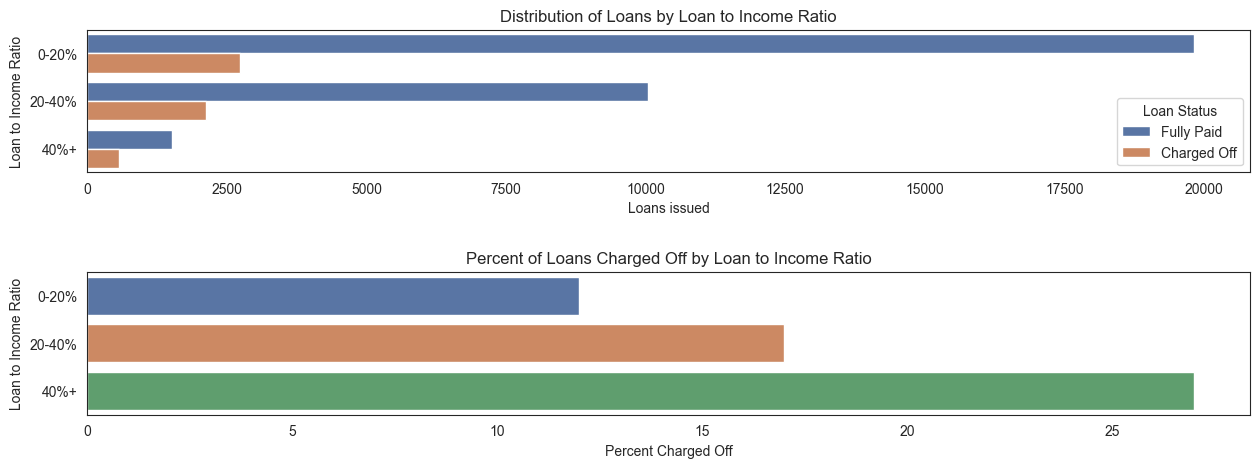

In [83]:
analysis_by_loan_status(df, "loan_ratio_range", display_name="Loan to Income Ratio")

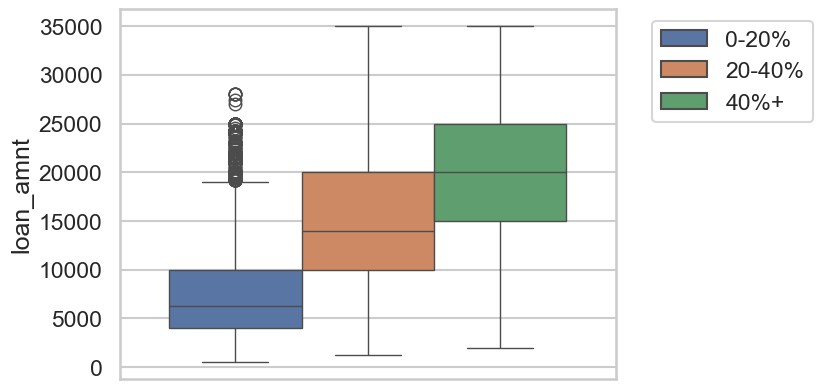

In [101]:
sns.boxplot(data=df, y="loan_amnt", hue="loan_ratio_range")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

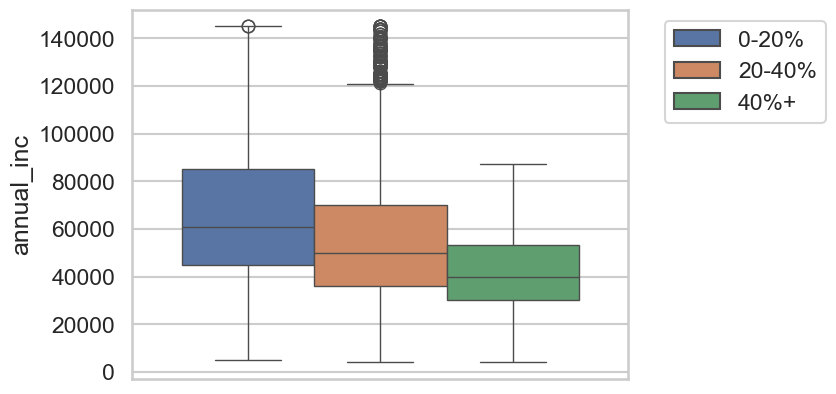

In [100]:
sns.boxplot(data=df, y="annual_inc", hue="loan_ratio_range")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<Figure size 640x480 with 0 Axes>

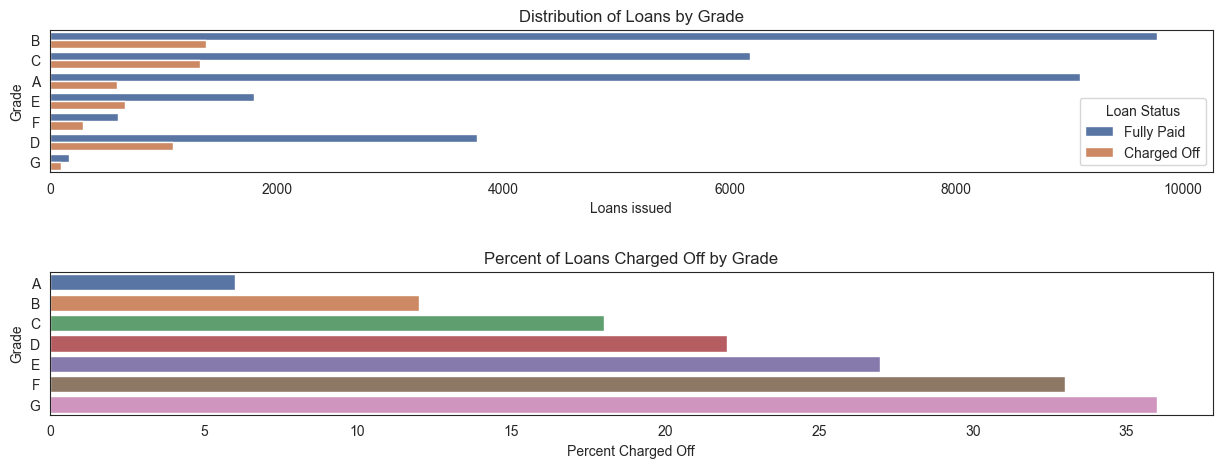

In [84]:
analysis_by_loan_status(df, "grade", display_name="Grade")

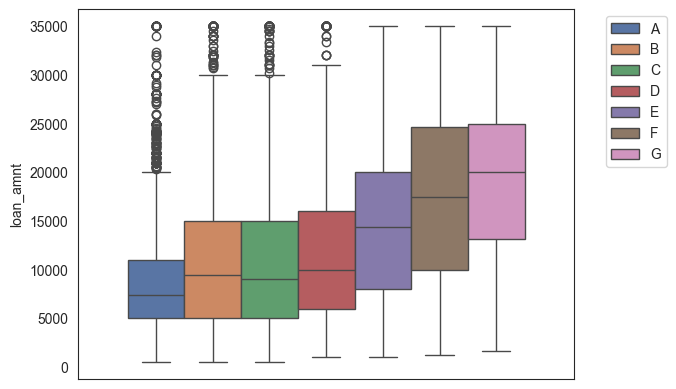

In [85]:
sns.boxplot(data=df, y="loan_amnt", hue="grade", hue_order=["A","B","C","D", "E", "F", "G"])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<Figure size 640x480 with 0 Axes>

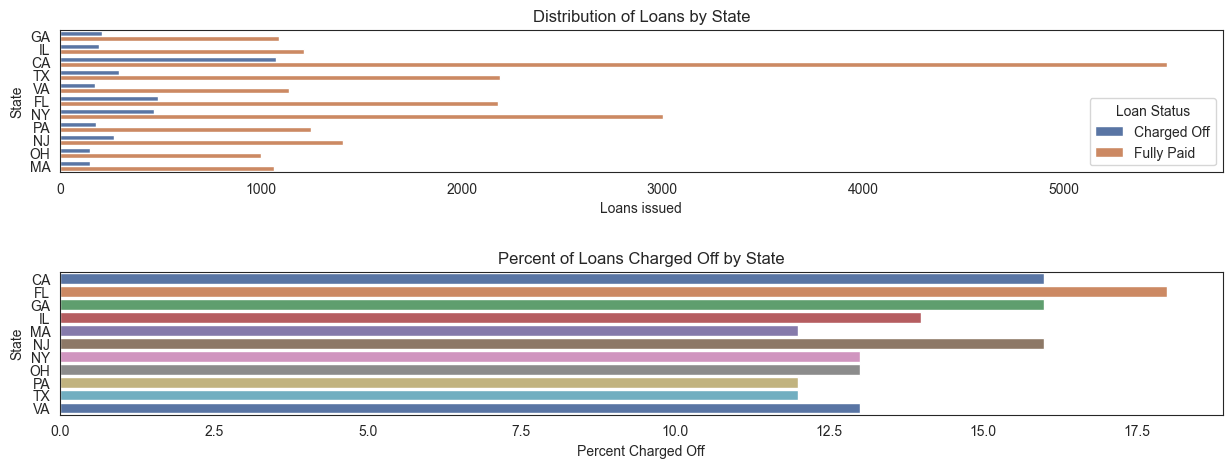

In [86]:
analysis_by_loan_status(df, "addr_state", display_name="State", top_k=11) # Lot of states. Lets take top 11 which has more than 1K loans issued

<Figure size 640x480 with 0 Axes>

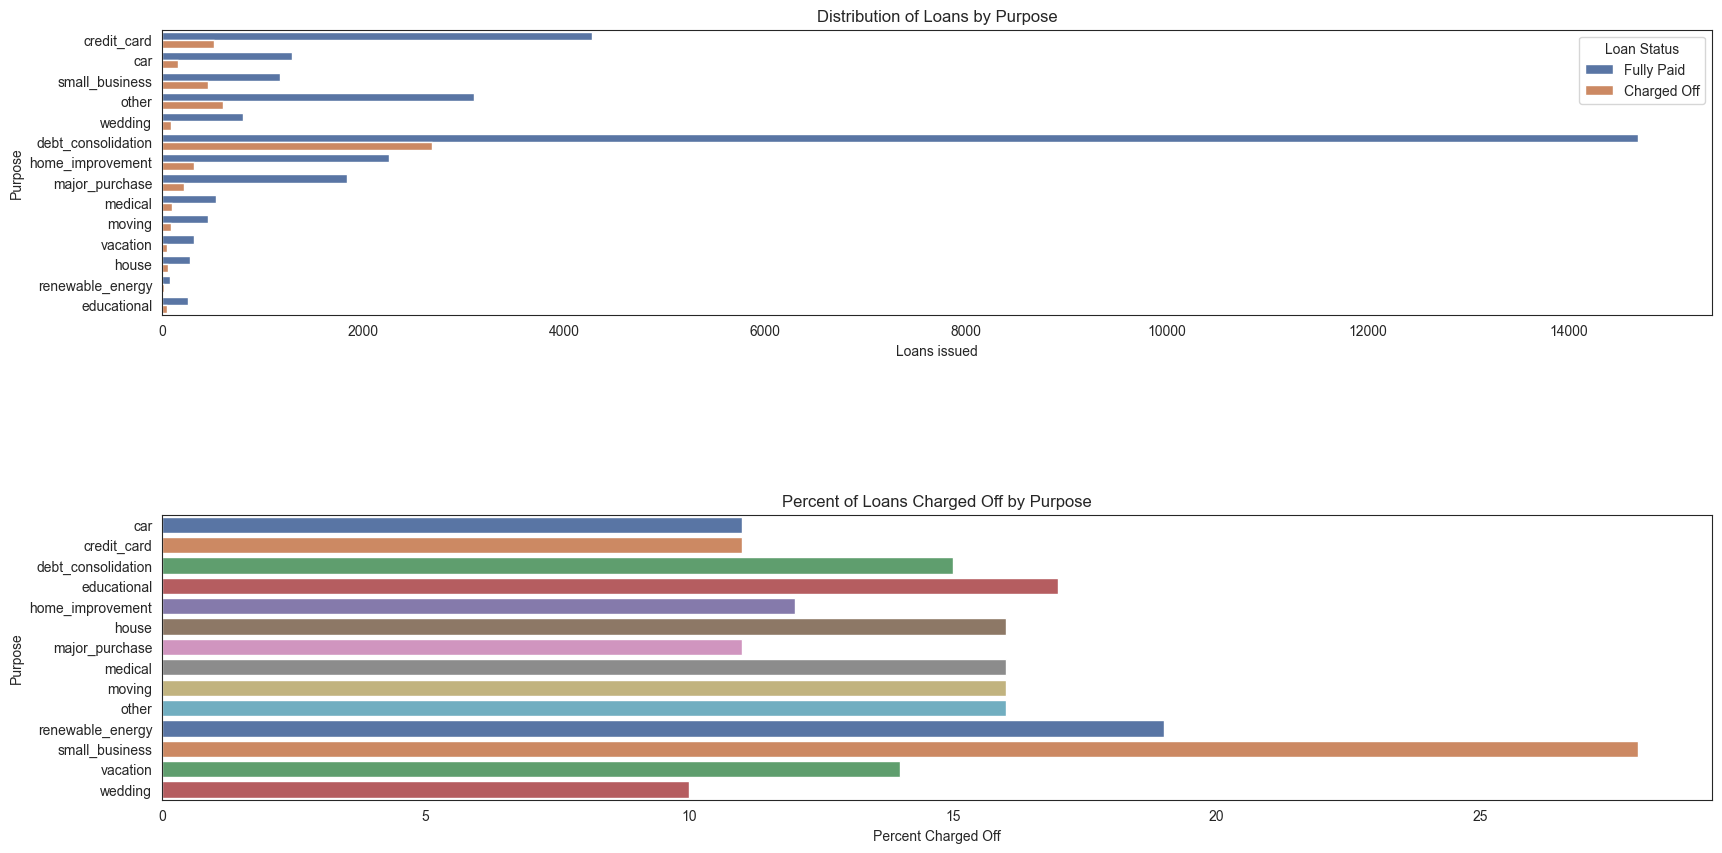

In [87]:
analysis_by_loan_status(df, "purpose", display_name="Purpose", figsize=(20,10))

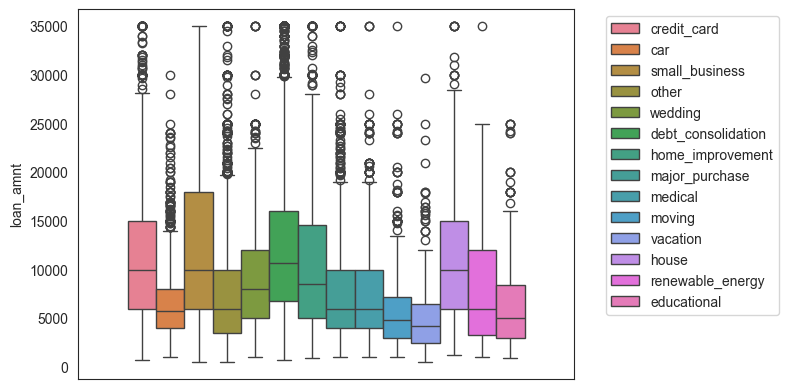

In [88]:
sns.boxplot(data=df, y="loan_amnt", hue="purpose")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<Figure size 640x480 with 0 Axes>

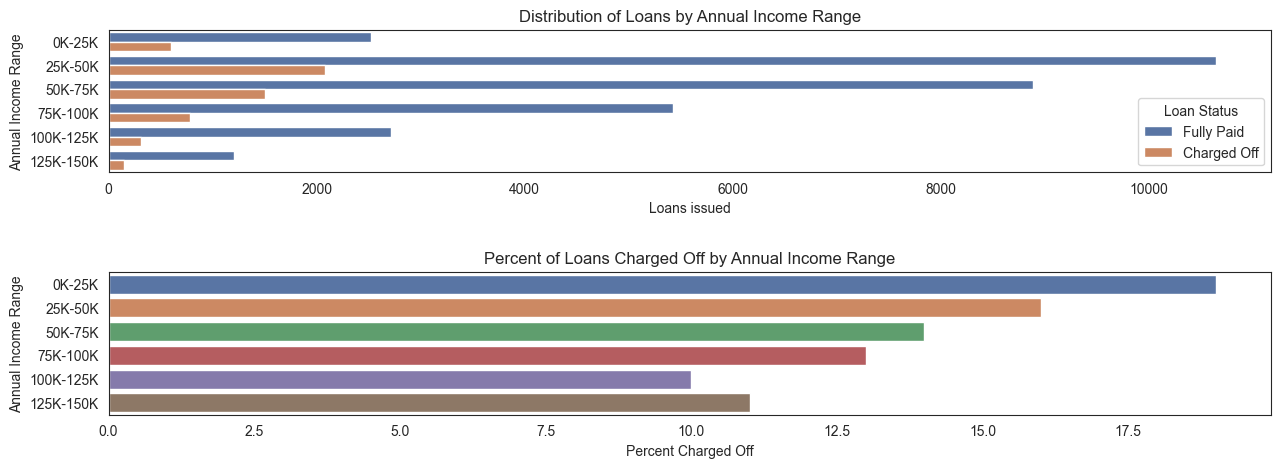

In [89]:
analysis_by_loan_status(df, "annual_inc_range", display_name="Annual Income Range")

<Figure size 640x480 with 0 Axes>

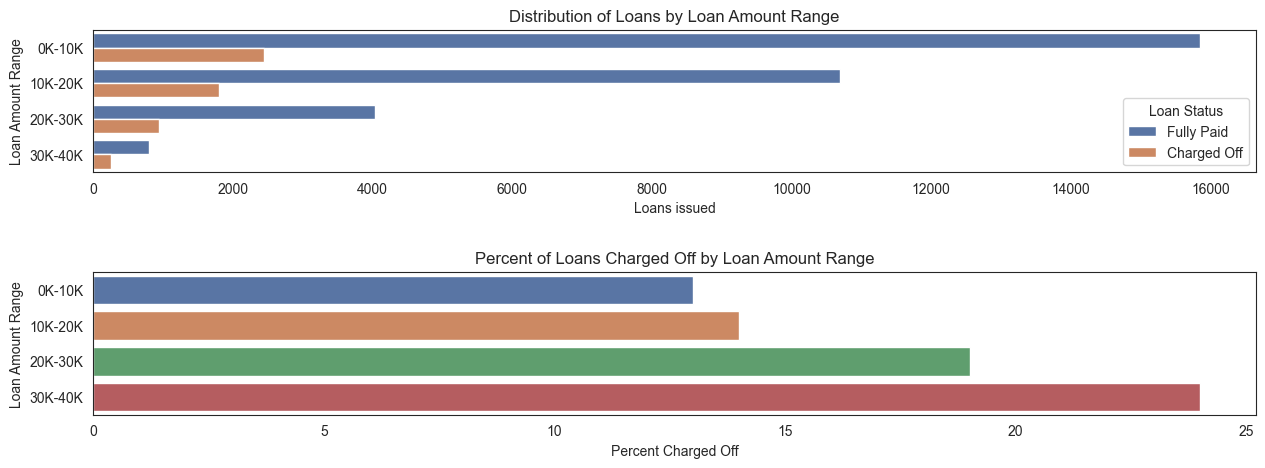

In [90]:
analysis_by_loan_status(df, "loan_amnt_range", display_name="Loan Amount Range")

In [91]:
def plot_categorical_data(data, category_column, hue_column=None, description=''):
    sns.set_style("whitegrid")
    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(12, 6))
    plot = sns.countplot(data=data, x=category_column, hue=hue_column, palette="Set2")

    total_count = len(data)
    for p in plot.patches:
        percentage = (p.get_height() / total_count) * 100
        ax.annotate('{:.1f}%'.format(percentage), (p.get_x() + p.get_width() / 2, p.get_height() + 10),
                    ha='center', fontsize=12)

    plt.xlabel(category_column)
    plt.ylabel(f"Count" )
    plt.title(f"Categorical Data Distribution of {description}")
    plt.legend(title=hue_column)
    plt.tight_layout()
    plt.show()

In [92]:
cont_columns

['loan_amnt', 'annual_inc', 'int_rate', 'dti']

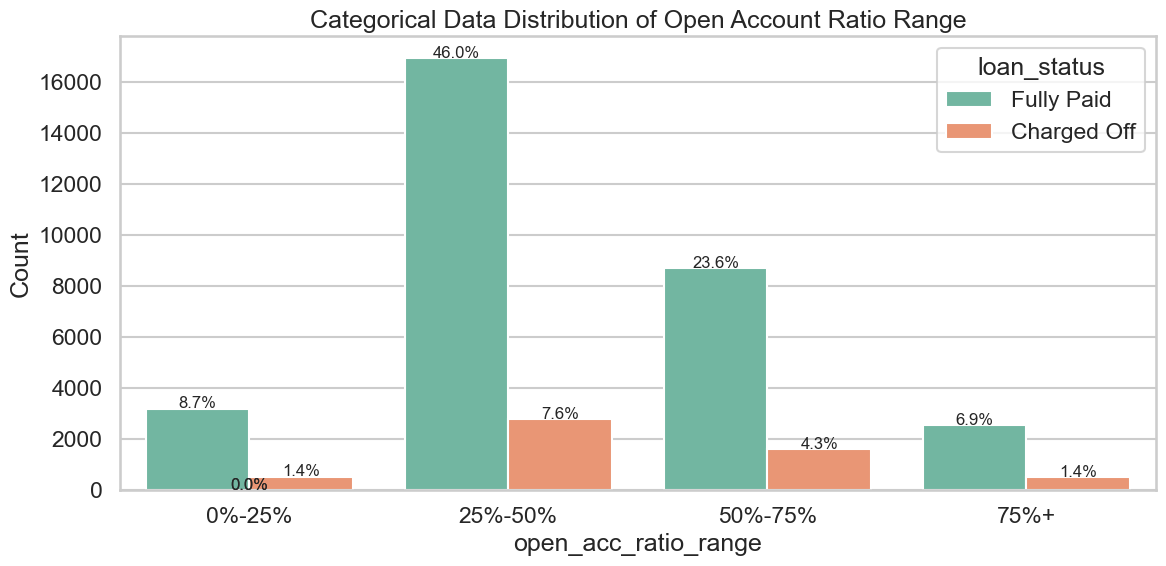

In [93]:
plot_categorical_data(df,'open_acc_ratio_range', 'loan_status', 'Open Account Ratio Range')

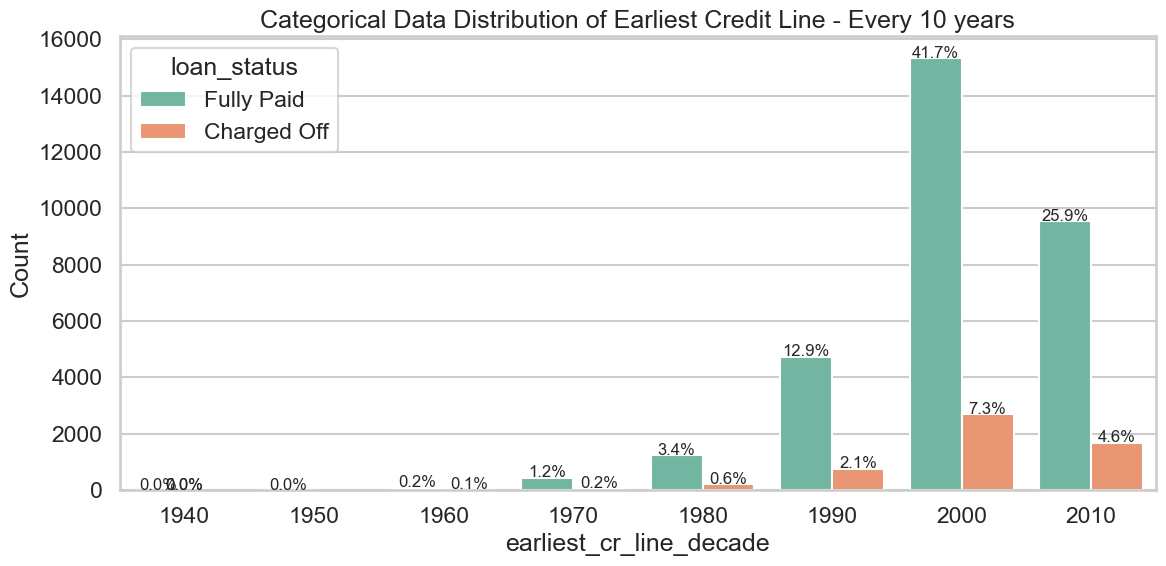

In [94]:
plot_categorical_data(df,'earliest_cr_line_decade', 'loan_status' ,"Earliest Credit Line - Every 10 years")

In [95]:
cont_columns

['loan_amnt', 'annual_inc', 'int_rate', 'dti']

In [96]:
def bivariate_continuos(df,x_var):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_var, y='loan_status', data=df, palette='Set2')

    # Add labels and a title
    plt.xlabel(x_var)
    plt.ylabel('Loan Status')
    plt.title(f'Bivariate Boxplot Analysis for {x_var} with Loan Status')

    # Show the plot
    plt.tight_layout()
    return plt.show()



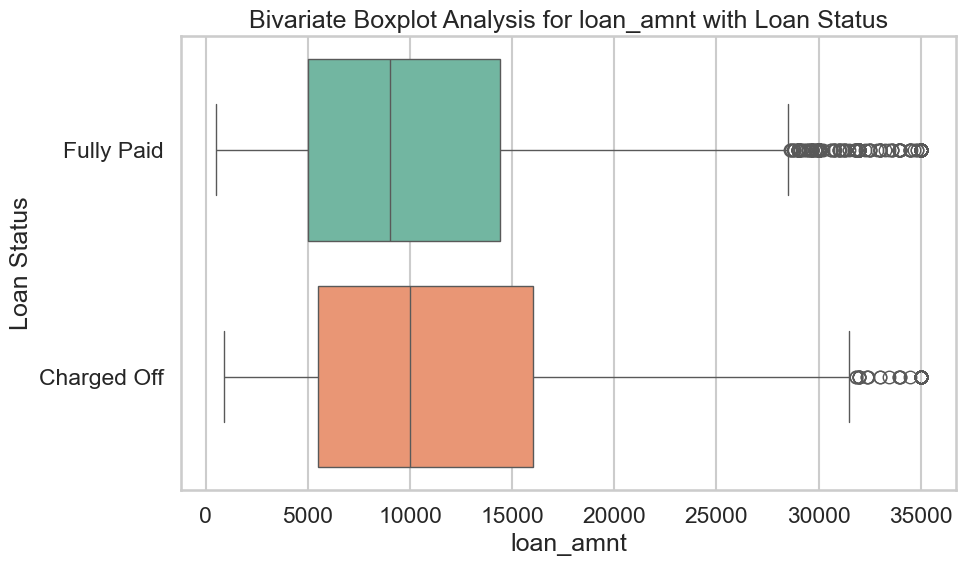

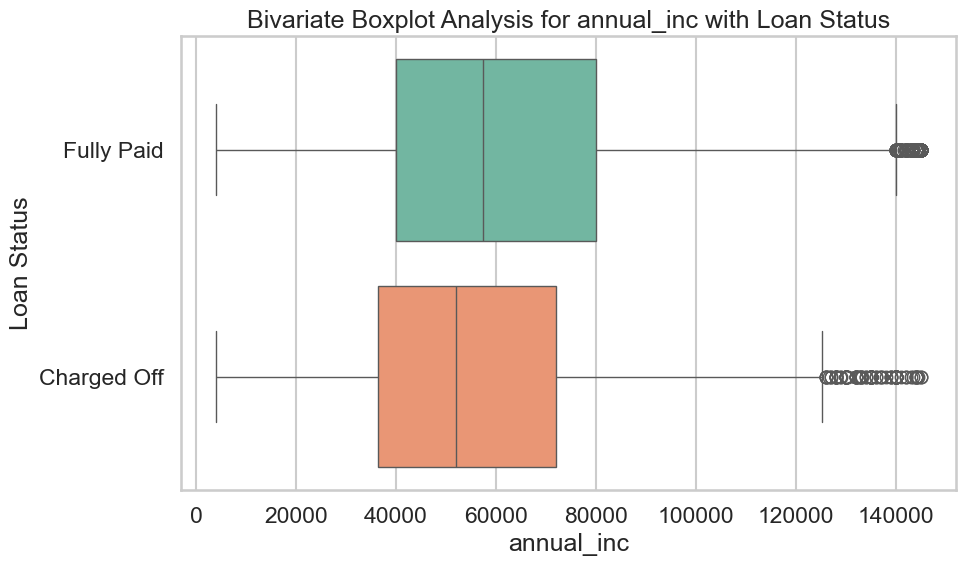

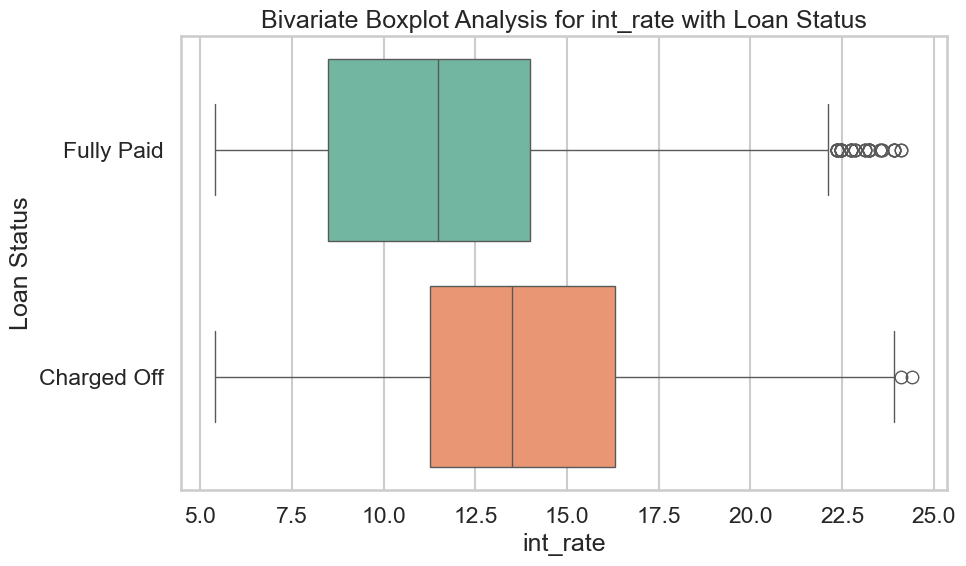

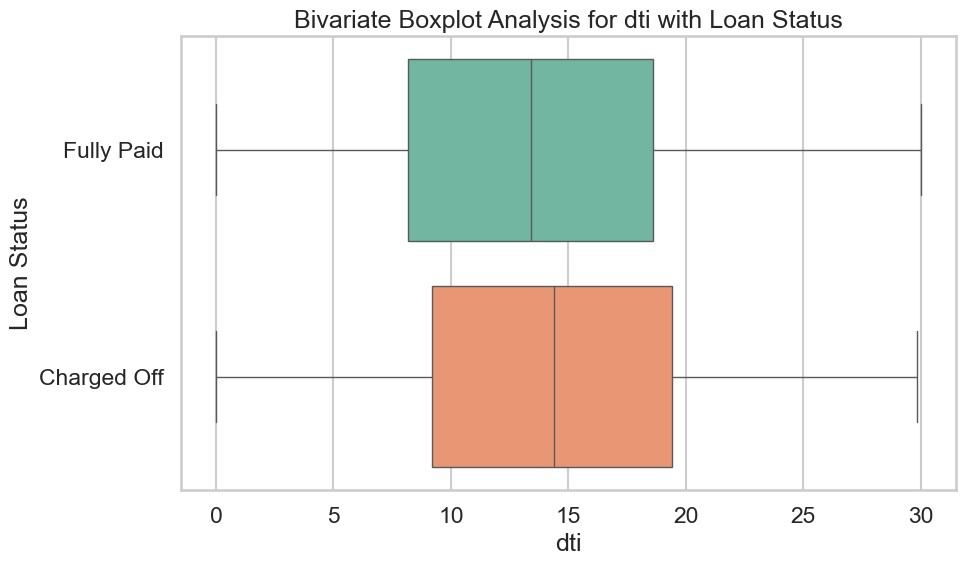

In [97]:
for x_var in cont_columns:
    bivariate_continuos(df,x_var)

<Figure size 640x480 with 0 Axes>

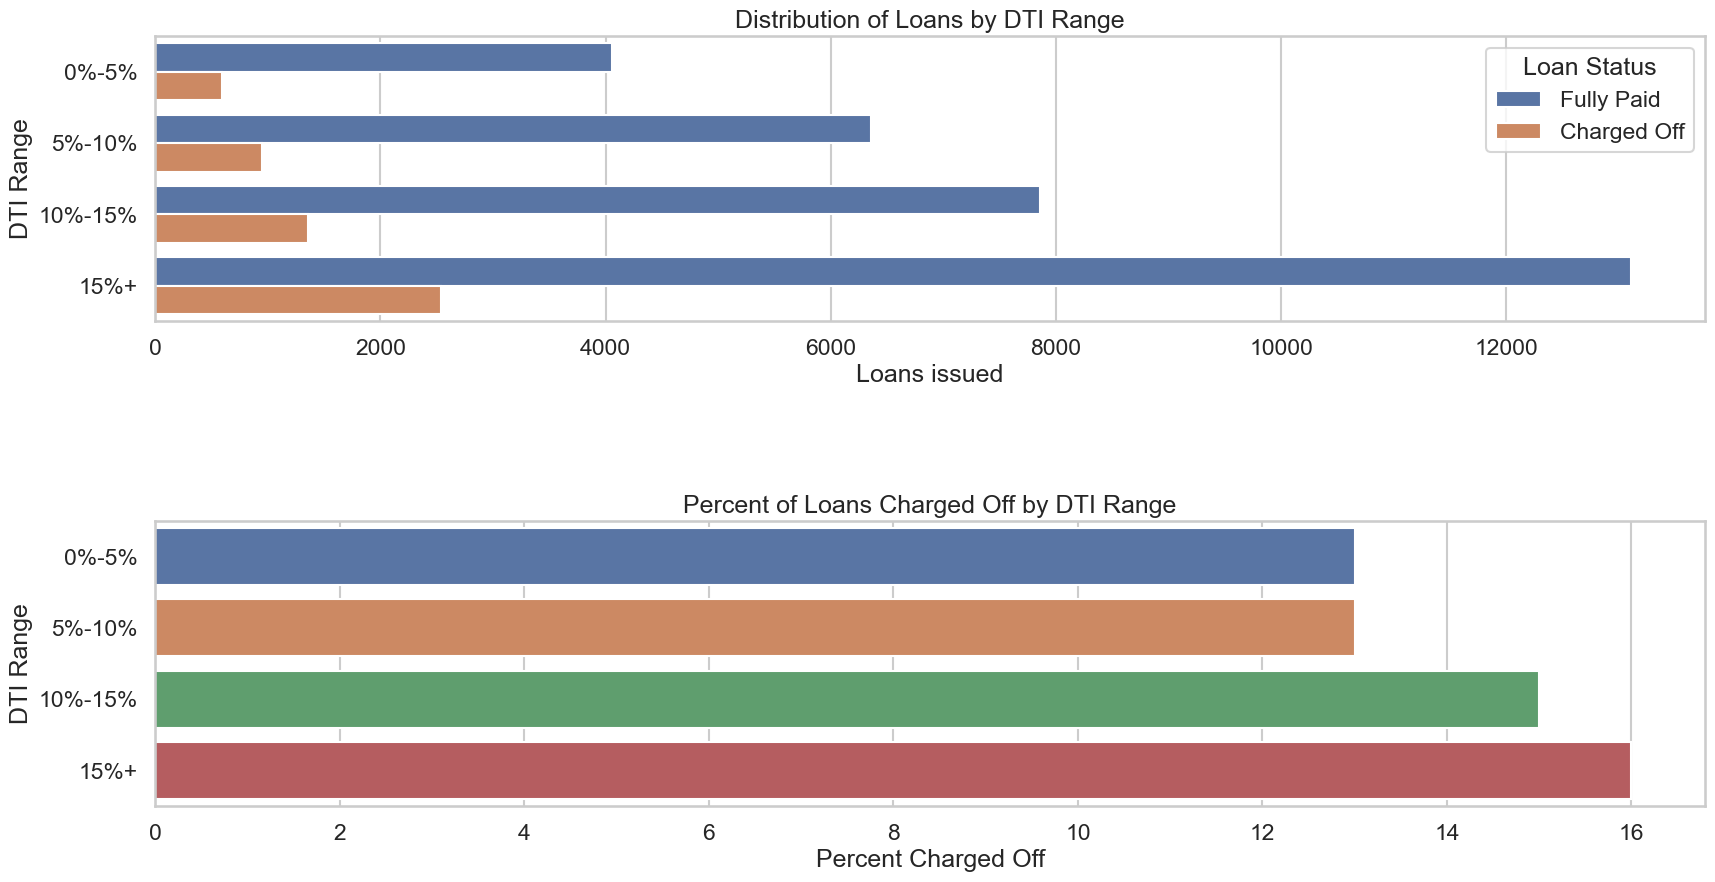

In [104]:
analysis_by_loan_status(df, "dti_range", display_name="DTI Range", figsize=(20,10))

<Figure size 640x480 with 0 Axes>

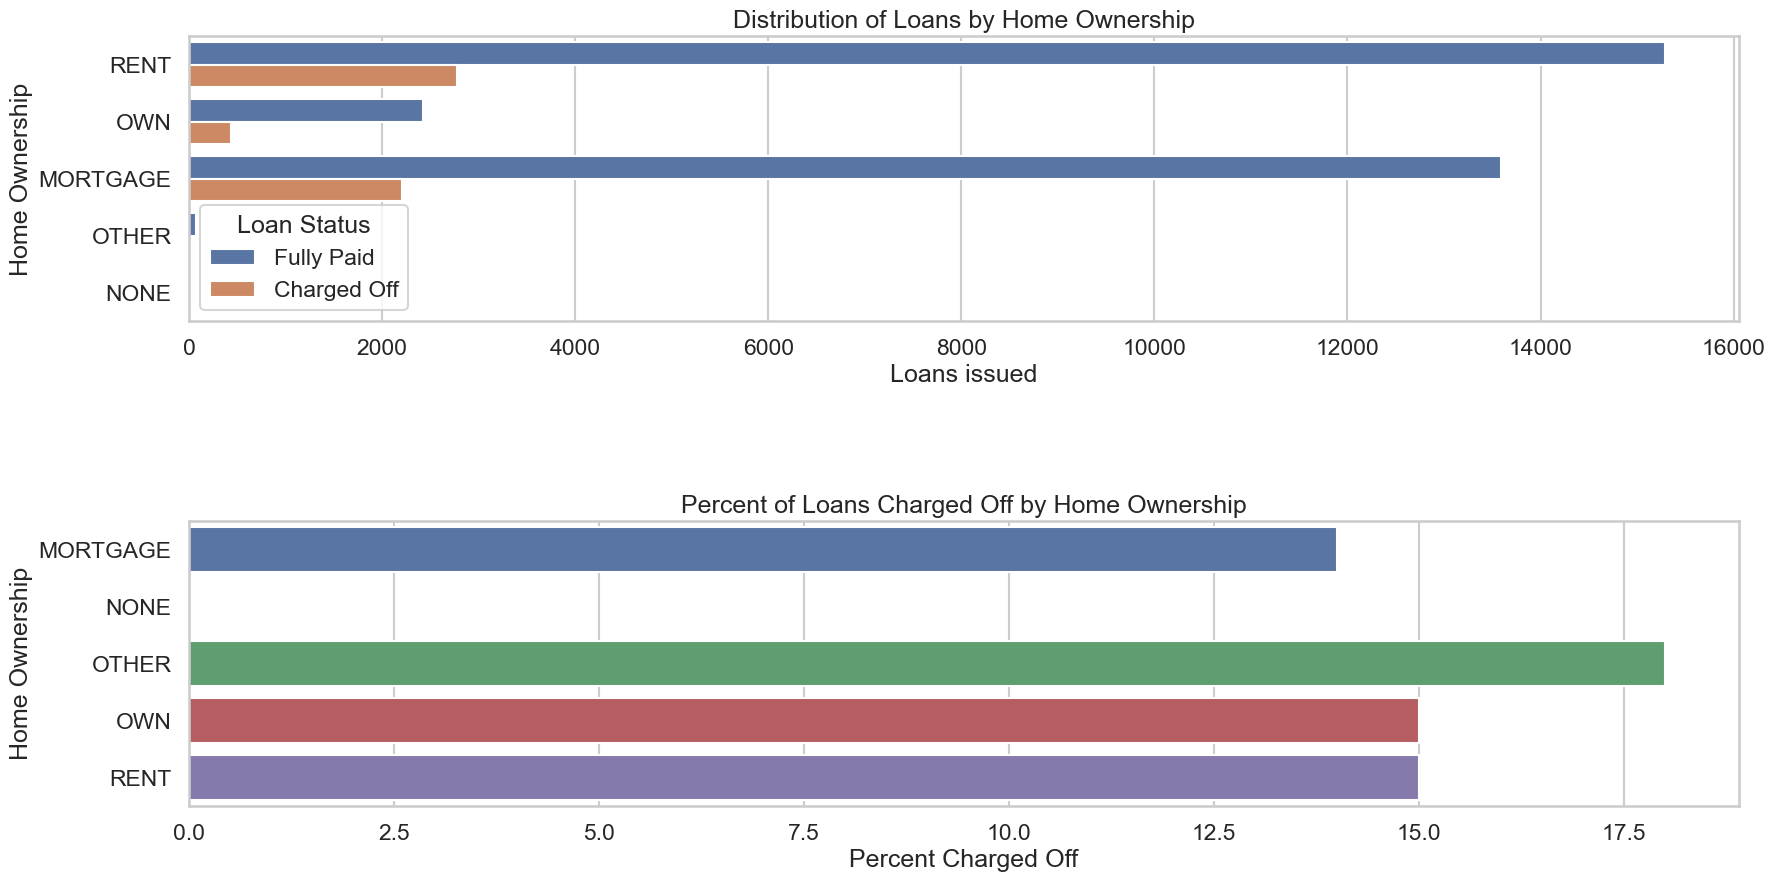

In [105]:
analysis_by_loan_status(df, "home_ownership", display_name="Home Ownership", figsize=(20,10))